In [1]:
import sys
# Replace '/path/to/root' with the actual path to the root directory
sys.path.append('/storage/brno2/home/zovi/lvd')
# sys.path.append('/storage/brno2/home/zovi/lvd/chromadb')

In [2]:
import json
import numpy as np
from tqdm.notebook import tqdm
import statistics
import matplotlib.pyplot as plt
import chromadb
import seaborn as sns
import pandas as pd
import json
import time
import os
from matplotlib.patches import Patch

# LVD Filtering Benchmark on Keyword dataset

This notebooks allows for conducting basci experoments and visualizations on match keyword filtering dataset.
The notebook was orginally designed for [H&M](https://github.com/qdrant/ann-filtering-benchmark-datasets?tab=readme-ov-file) dataset encoded with Efficientnet for experiments. Original the data is from [Kaggle](https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/data). 

## Load data

In [3]:
dataset_name = "random_keywords_100k"
dir_path = f"data/{dataset_name}/"
vectors_path = dir_path + "vectors.npy"
payloads_path = dir_path + "payloads.jsonl"
tests_path = dir_path + "tests.jsonl"

# Load vectors as numpy array
vectors = np.load(vectors_path)

# Load payloads.jsonl as python list
with open(payloads_path, 'r') as file:
    payloads = [json.loads(line) for line in file]

# Load tests.jsonl as python list
with open(tests_path, 'r') as file:
    tests = [json.loads(line) for line in file]

(vectors.shape, len(payloads), len(tests))


((100000, 50), 100000, 1000)

### Check whether filter have same format and preprocess dataset

In [4]:
def preprocess_payloads(payloads):
    """
    Preprocess payloads replacing None values with the string 'None'.
    :param payloads: A list of payload entries
    :return: The preprocessed list of payloads
    """
    for payload in payloads:
        for key, value in payload.items():
            if value is None:
                payload[key] = 'None'

preprocess_payloads(payloads)

#### Metadata Example

In [5]:
print(json.dumps(payloads[0], indent=4, sort_keys=True))

{
    "a": "TgGcP",
    "b": "WBiVe"
}


#### Query Restrictivness Distribution

In [6]:
def apply_condition(payloads, condition):
    """
    Apply a given condition to the list of payloads and return the filtered list.
    """
    filtered_payloads = []
    filtered_payloads_ids = []

    # Check if the condition is 'and' or 'or' and process accordingly
    if 'and' in condition:
        for i, payload in enumerate(payloads):
            if all(payload.get(key, None) == val['match']['value'] for cond in condition['and'] for key, val in cond.items()):
                filtered_payloads.append(payload)
                filtered_payloads_ids.append(str(i))
    elif 'or' in condition:
        for i, payload in enumerate(payloads):
            if any(payload.get(key, None) == val['match']['value'] for cond in condition['or'] for key, val in cond.items()):
                filtered_payloads.append(payload)
                filtered_payloads_ids.append(str(i))

    return filtered_payloads, filtered_payloads_ids

In [7]:
ratios = []

for condition in [tests[i]['conditions'] for i in range(len(tests))]:
    filtered_payloads, _ = apply_condition(payloads, condition)
    ratio = len(filtered_payloads) / len(payloads)
    ratios.append(ratio)

In [8]:
def visualize_ratios(ratios):
    # Define the intervals (bins)
    bins = np.linspace(0.0, 0.5, num=11)  # 11 edges for 10 bins
    
    # Count the number of ratios in each bin
    hist, _ = np.histogram(ratios, bins)
    
    # Plotting the bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(bins[:-1], hist, width=0.05, align='edge', edgecolor='black')
    
    # Setting the x-axis limits
    plt.xlim(0, 0.5)
    
    # Adding labels and title
    plt.xlabel('Filter Restrictiveness')
    plt.ylabel('Count')
    plt.title('Filter Restrictiveness Distribution')
    
    # Show the plot
    plt.show()

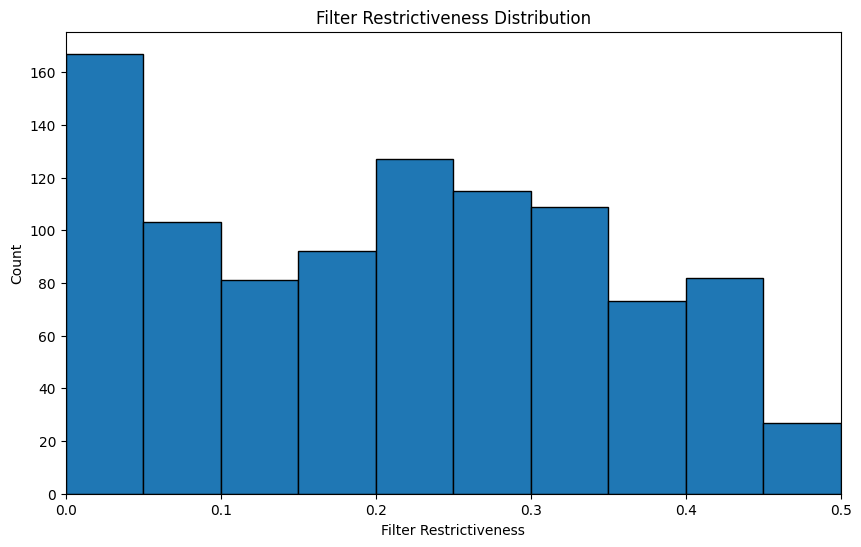

In [9]:
visualize_ratios(ratios)

In [10]:
lest_restrictive_condition = tests[np.argmax(ratios)]['conditions']
_, least_restrictive_condition_ids = apply_condition(payloads, lest_restrictive_condition)
print('Condition with the lowest restrictivness: \n', lest_restrictive_condition)

Condition with the lowest restrictivness: 
 {'or': [{'a': {'match': {'value': 'WBiVe'}}}, {'a': {'match': {'value': 'aMBUZ'}}}, {'a': {'match': {'value': 'bwDhc'}}}, {'a': {'match': {'value': 'rtJip'}}}, {'a': {'match': {'value': 'YBzfE'}}}]}


## Setup Database

In [11]:
# Configuration from SISAP 2023 Indexing Challenge - LMI except n_categories
index_configuraiton = {
    "lmi:epochs": "[200]",
    "lmi:model_types": "['MLP-4']",
    "lmi:lrs": "[0.01]",
    "lmi:n_categories": "[20]",
    "lmi:kmeans": "{'verbose': False, 'seed': 2023, 'min_points_per_centroid': 100}",
}

In [12]:
client = chromadb.Client()

collection_name = "synthetic_collection"
# client.delete_collection(collection_name)
collection = client.create_collection(
    name=collection_name,
    metadata=index_configuraiton
)

### Load data in batches

In [13]:
%%time
batch_size = 1000 # can large batch cause slow down?
dataset_size = vectors.shape[0]
for i in tqdm(range(0, dataset_size, batch_size), desc="Adding documents"):
    collection.add(
        embeddings=vectors[i: i + batch_size].tolist(),
        metadatas=payloads[i: i + batch_size],
        ids=[
            str(i) for i in range(i, min(i + batch_size, dataset_size))
        ]
    )

Adding documents:   0%|          | 0/100 [00:00<?, ?it/s]


            LMI Build Config:
            {
                clustering_algorithms: [<function cluster at 0x147dcf183310>],
                epochs: [200],
                model_types: ['MLP-4'],
                learning_rate: [0.01],
                n_categories: [20],
            }
             
CPU times: user 6min 49s, sys: 338 ms, total: 6min 50s
Wall time: 6min 50s


In [14]:
%%time
bucket_assignment = collection.build_index()

FAISS Kmeans parameters {'verbose': False, 'seed': 2023, 'min_points_per_centroid': 100}
LMI built with n_buckets_in_index: 20
Time taken to build: 211.887353181839; Time taken to cluster: 0.04917573928833008
CPU times: user 3min 28s, sys: 399 ms, total: 3min 28s
Wall time: 3min 32s


In [15]:
def plot_bucket_items(data, highlight_ids=None):
    """
    Plot the number of items in each bucket, with an optional overlay of highlighted items.

    Parameters:
    data (DataFrame): The data frame containing the 'id', 'bucket', and 'cluster' columns.
    highlight_ids (list, optional): List of ids to highlight in the visualization.
    """
    # Count the total number of items in each bucket
    bucket_counts = data.groupby('bucket_str').size()
    plot_data = bucket_counts.reset_index(name='count')

    # Create the bar plot for total items
    plt.figure(figsize=(10, 6))
    total_bars = sns.barplot(data=plot_data, x='bucket_str', y='count')

    # If highlight_ids is provided, overlay highlighted bars
    if highlight_ids is not None:
        # Filter data to include only highlighted ids
        highlighted_data = data[data['id'].isin(highlight_ids)]
        highlighted_counts = highlighted_data.groupby('bucket_str').size()
        highlighted_plot_data = highlighted_counts.reset_index(name='count')

        # Create overlay bar plot for highlighted items
        sns.barplot(data=highlighted_plot_data, x='bucket_str', y='count', color='red', alpha=0.7)

        # Create custom legend
        legend_elements = [Patch(facecolor=total_bars.patches[0].get_facecolor(), label='Total Items in Bucket'),
                           Patch(facecolor='red', alpha=0.5, label='Items Satisfying Condition in Bucket')]
        plt.legend(handles=legend_elements)

    if highlight_ids is not None:
        plt.title('Number of Items in Each Bucket For Query With Lowest Restrictiveness')
    else:
        plt.title('Number of Items in Each Bucket')
    plt.xlabel('Bucket')
    plt.ylabel('Count')

    # Annotate each bar with the count of elements
    for p in total_bars.patches:
        bar_height = int(p.get_height())
        if bar_height > 0:  # Only annotate bars with a height greater than zero
            total_bars.annotate(f'{bar_height}', (p.get_x() + p.get_width() / 2., bar_height),
                                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                                textcoords='offset points')

In [16]:
data_buckets = pd.DataFrame([str(i) for i in range(vectors.shape[0])], columns=["id"])
data_buckets['bucket'] = data_buckets['id'].map(lambda x: list(bucket_assignment.get(x, [])))
data_buckets['bucket_str'] = data_buckets['bucket'].apply(lambda x: str(x))

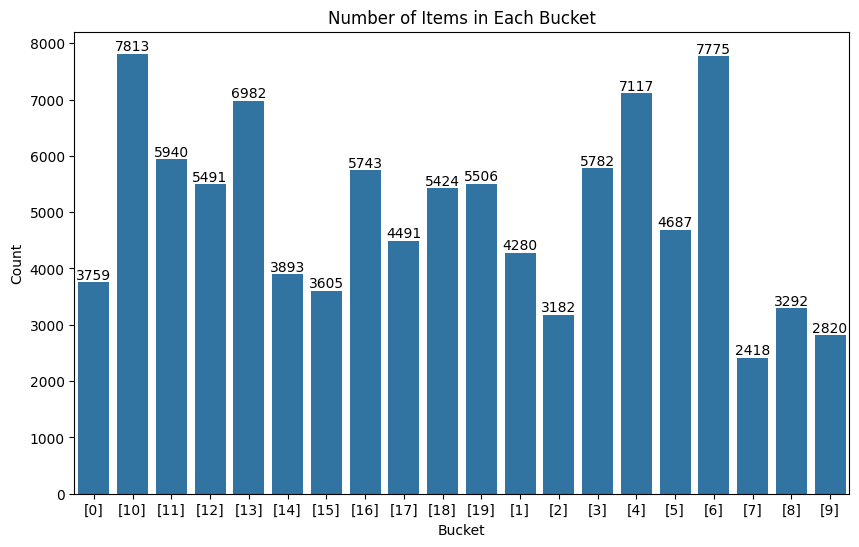

In [17]:
plot_bucket_items(data_buckets)

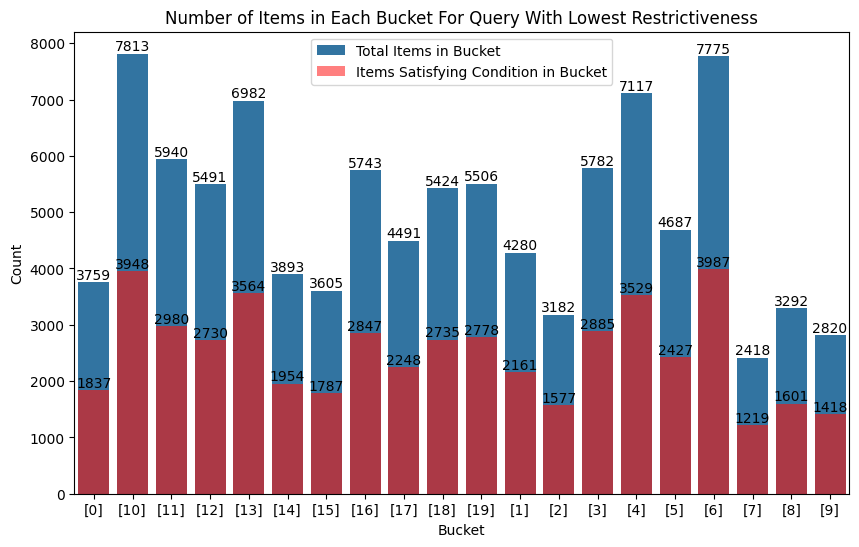

In [18]:
plot_bucket_items(data_buckets, highlight_ids=least_restrictive_condition_ids)

## Query Database

In [19]:
print('\n ------- Query Example ------- \n')
print('Vector: ' + str(tests[0]['query'][:5]).rstrip("]") + ", ... ]")
print('Constraint: ', tests[0]['conditions'])

print('\n ------- Ground Truth For The Query ------- \n')
print('Ground truth: ', tests[0]['closest_ids'])
print('Closest scores: '+ str(tests[0]['closest_scores'][:5]).rstrip("]") + ", ... ]")


 ------- Query Example ------- 

Vector: [0.53135746717453, 0.749967634677887, 0.5464516282081604, 0.3592023551464081, 0.0913628339767456, ... ]
Constraint:  {'and': [{'a': {'match': {'value': 'TgGcP'}}}]}

 ------- Ground Truth For The Query ------- 

Ground truth:  [7521, 52267, 11648, 98402, 87670, 55422, 13160, 50165, 10475, 1979, 76854, 10302, 25147, 10749, 13518, 48154, 12532, 59990, 86321, 55008, 86667, 95575, 25315, 80086, 67854]
Closest scores: [0.8924813866615295, 0.8918411135673523, 0.886002779006958, 0.8822261691093445, 0.8819704055786133, ... ]


In [20]:
def convert_condition(input_condition):
    output_condition = {}

    # Iterate through the keys ('and'/'or') and their list of conditions
    for key, conditions in input_condition.items():
        output_key = f"${key}"
        output_conditions = []

        # Process each condition in the list
        for condition in conditions:
            for field, match in condition.items():
                # Assume 'match' is always present as per input format
                value = match['match']['value']
                output_conditions.append({field: value})

        # If there's only one condition in 'and'/'or', do not use '$and'/'$or'
        if len(output_conditions) == 1 and key in ['and', 'or']:
            output_condition = output_conditions[0]
        else:
            output_condition[output_key] = output_conditions

    return output_condition

In [21]:
def convert_condition_to_simple_dict(condition):
    key = list(condition['and'][0].keys())[0]  # Extract key from the first item
    value = condition['and'][0][key]['match']['value']  # Extract value from the nested structure
    return {key: value}

def calculate_precision(relevant_ids, retrieved_ids):
    # If there are no relevant IDs and no retrieved IDs, precision is 1
    if len(relevant_ids) == 0 and len(retrieved_ids) == 0:
        return 1
    
    retrieved_ids = set(map(int, retrieved_ids))
    relevant_ids = set(relevant_ids)
    true_positives = len(relevant_ids & retrieved_ids)
    
    return true_positives / len(retrieved_ids) if retrieved_ids else 0

In [38]:
def perform_queries(total_queries, constraint_weight, bruteforce_threshold, n_buckets=1, search_until_bucket_not_empty=False):
    queries_results = []
    
    for query_id in range(total_queries):
        test_query_object = tests[query_id]
        start = time.time()
        results = collection.query(
            query_embeddings=test_query_object["query"],
            include=["metadatas"],
            where=convert_condition(test_query_object["conditions"]),
            n_results=25,
            n_buckets=n_buckets,
            constraint_weight=constraint_weight,
            bruteforce_threshold=bruteforce_threshold,
            search_until_bucket_not_empty=search_until_bucket_not_empty
        )
        end = time.time()
        wall_time = end - start
        results['wall_time'] = wall_time
        
        queries_results.append(results)
        
    return queries_results

### Constraint Parameter Visualization

In [39]:
def percision_per_restrictiveness(vis_queries_filter_restrictiveness, vis_queries_precision_lmi, constrint_weight, bruteforce_threshold):
    # Create a DataFrame for easy plotting
    data = pd.DataFrame({
        'Filter Restrictiveness': vis_queries_filter_restrictiveness,
        'Precision LMI': vis_queries_precision_lmi
    })
    
    bin_edges = np.arange(-0.05, 0.55, 0.1) # six bins centered around 0.0, 0.1, ..., 0.5
    
    # Cut the data into bins
    bin_indices = pd.cut(data['Filter Restrictiveness'], bins=bin_edges, include_lowest=True, labels=False)
    
    # Initialize bin_medians array with zeros (or any default value) for each bin
    bin_medians = np.zeros(len(bin_edges) - 1)

    # Calculate the median for each bin and update the corresponding index in bin_medians
    grouped_data = data.groupby(bin_indices)['Precision LMI']
    for i in range(len(bin_edges) - 1):
        if i in grouped_data.groups:
            bin_medians[i] = grouped_data.get_group(i).median()
        else:
            bin_medians[i] = 0  # Default value for bins with no data
    
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Plot the histogram in the first subplot
    ax1.bar(bin_edges[:-1], bin_medians, width=0.1, align='edge', edgecolor='black')
    ax1.set_xlabel('Filter Restrictiveness')
    ax1.set_ylabel('Mean Precision LMI')
    ax1.set_title(f'Median Precision LMI by Filter Restrictiveness With CW {constrint_weight} and BT {bruteforce_threshold}')

    # Plot the scatter plot in the second subplot
    ax2.scatter(data['Filter Restrictiveness'], data['Precision LMI'], alpha=0.7)
    ax2.set_xlabel('Filter Restrictiveness')
    ax2.set_ylabel('Precision LMI')
    ax2.set_title('Scatter Plot of Precision LMI vs Filter Restrictiveness')

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

In [40]:
cw_test = {}
cw_grid = [-1, 0.5, 0.25, 0.75]

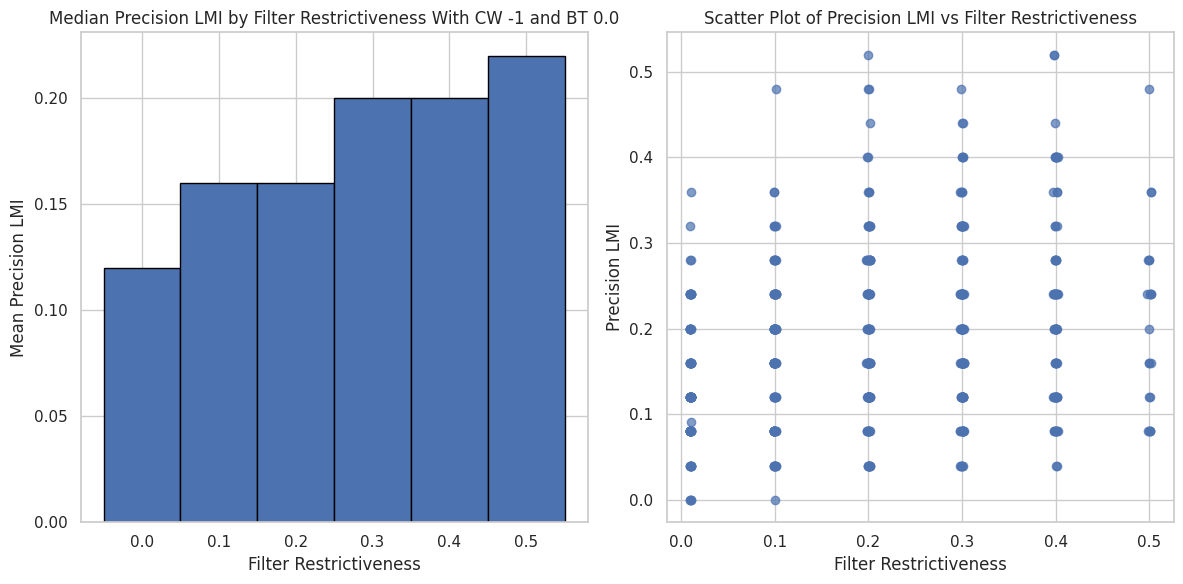

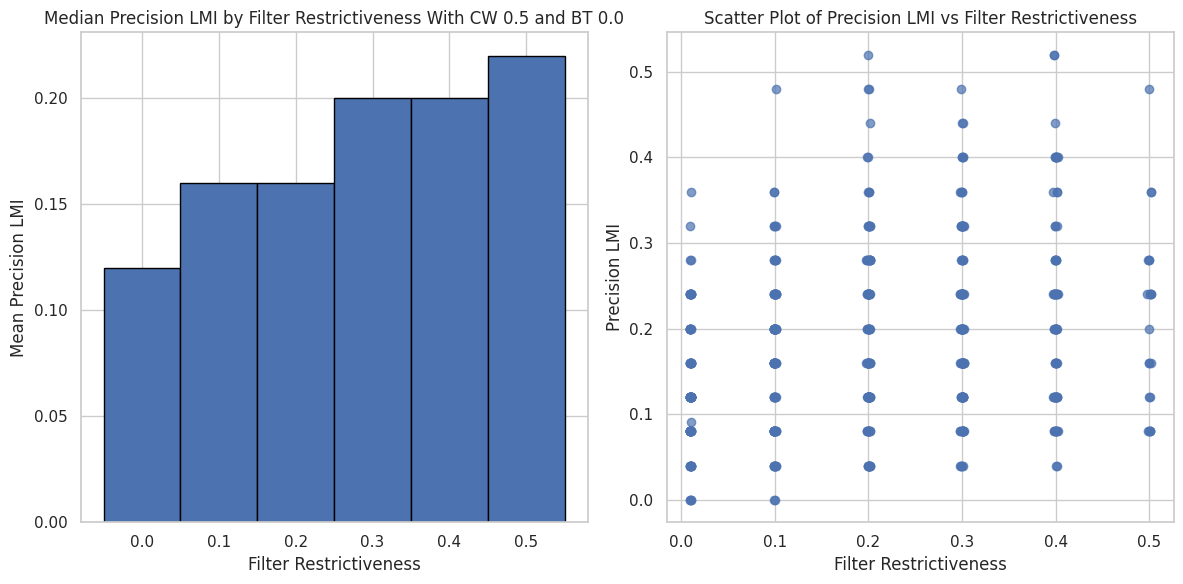

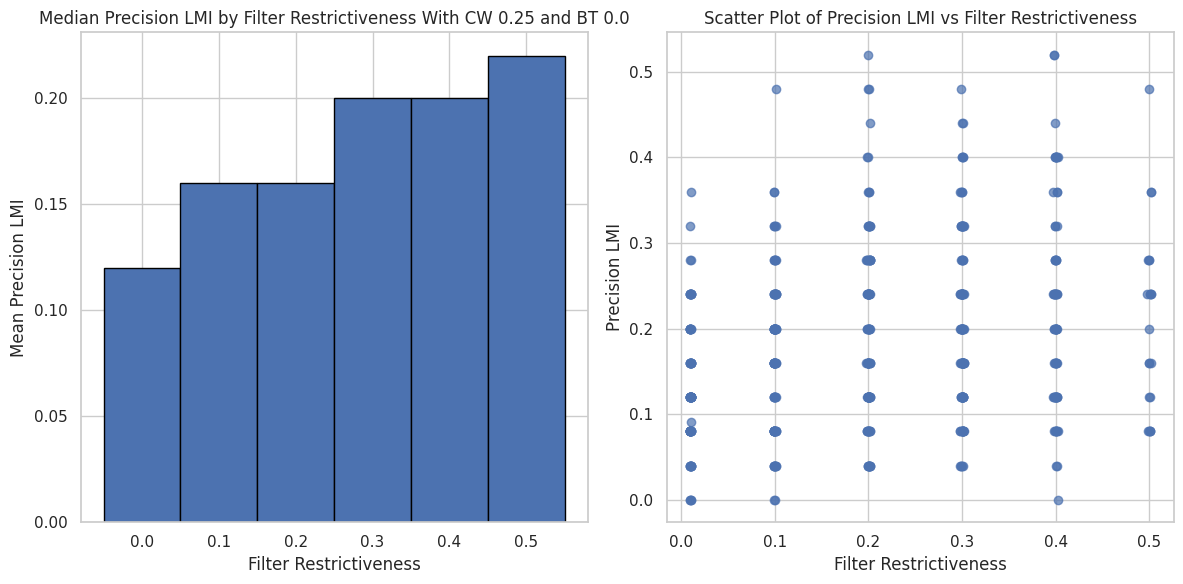

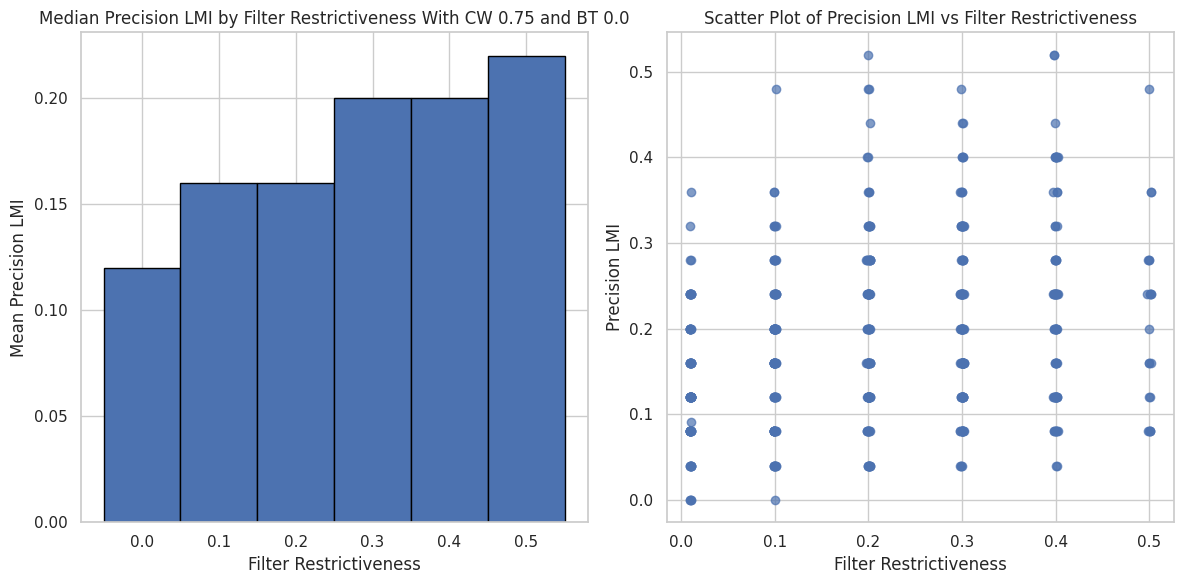

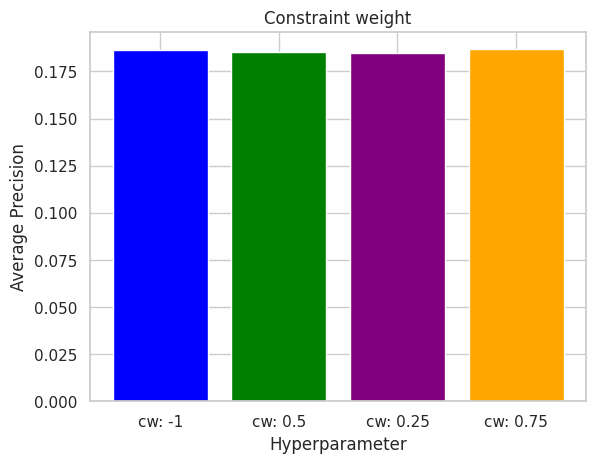

In [41]:
bruteforce_for_cws = 0.0

for cw in cw_grid:
    vis_queries_evaluated = perform_queries(500, cw, bruteforce_for_cws, 1, False)
    
    vis_lmi_indexes = []
    
    for i, result in enumerate(vis_queries_evaluated):
        if not result['bruteforce_used']:
            vis_lmi_indexes.append(i)
    
    # I want to evaluate only queries that used LMI
    # With bruteforce_for_cws=0.0 this will always pass
    assert len(vis_lmi_indexes) >= 100
    # vis_lmi_indexes = vis_lmi_indexes[:100]
    
    vis_queries_precision = list((calculate_precision(tests[i]["closest_ids"], result['ids'][0]) for i, result in enumerate(vis_queries_evaluated)))
    vis_queries_filter_restrictiveness = list(result['filter_restrictiveness'] for result in vis_queries_evaluated)
    
    vis_queries_precision_lmi = [vis_queries_precision[i] for i in vis_lmi_indexes]
    vis_queries_filter_restrictiveness = [vis_queries_filter_restrictiveness[i] for i in vis_lmi_indexes]
    
    percision_per_restrictiveness(vis_queries_filter_restrictiveness, vis_queries_precision_lmi, cw, 0.0)
    cw_test[f"cw: {cw}"] = sum(vis_queries_precision_lmi)/len(vis_queries_precision_lmi)
    
# Extracting keys and values
keys = list(cw_test.keys())
values = list(cw_test.values())

# Creating the bar chart
plt.bar(keys, values, color=['blue', 'green', 'purple', 'orange'])

# Adding labels and title
plt.xlabel('Hyperparameter')
plt.ylabel('Average Precision')
plt.title('Constraint weight')

# Displaying the plot
plt.show()

In [42]:
cw_test

{'cw: -1': 0.18610181818181798,
 'cw: 0.5': 0.18546181818181795,
 'cw: 0.25': 0.18482181818181798,
 'cw: 0.75': 0.18674181818181793}

### Bruteforce Threshold Parameter Visualization

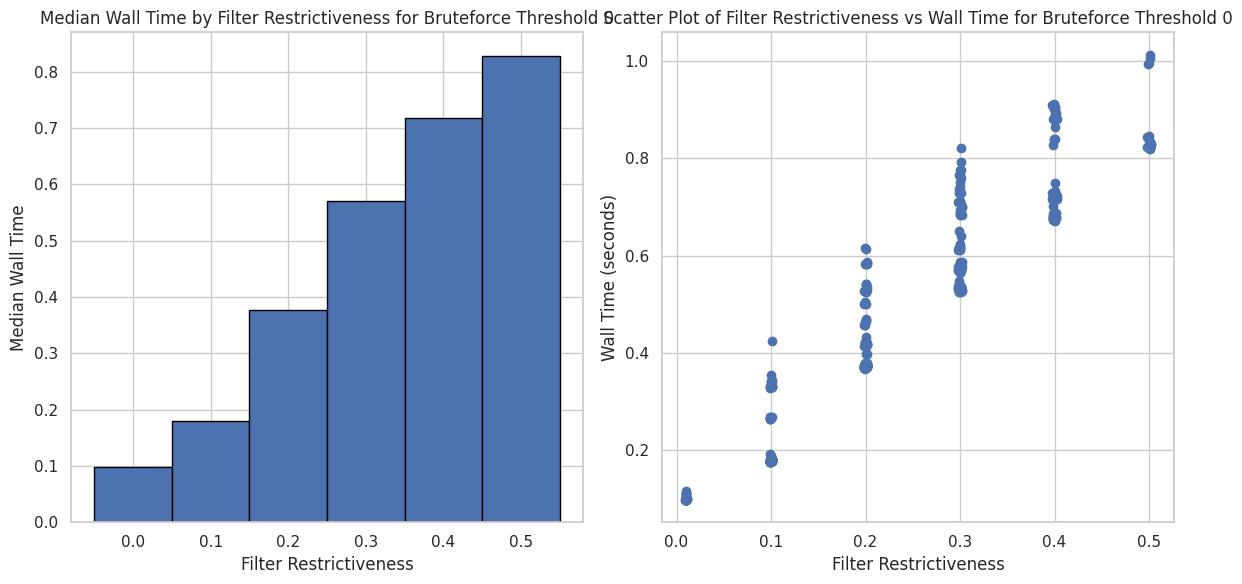

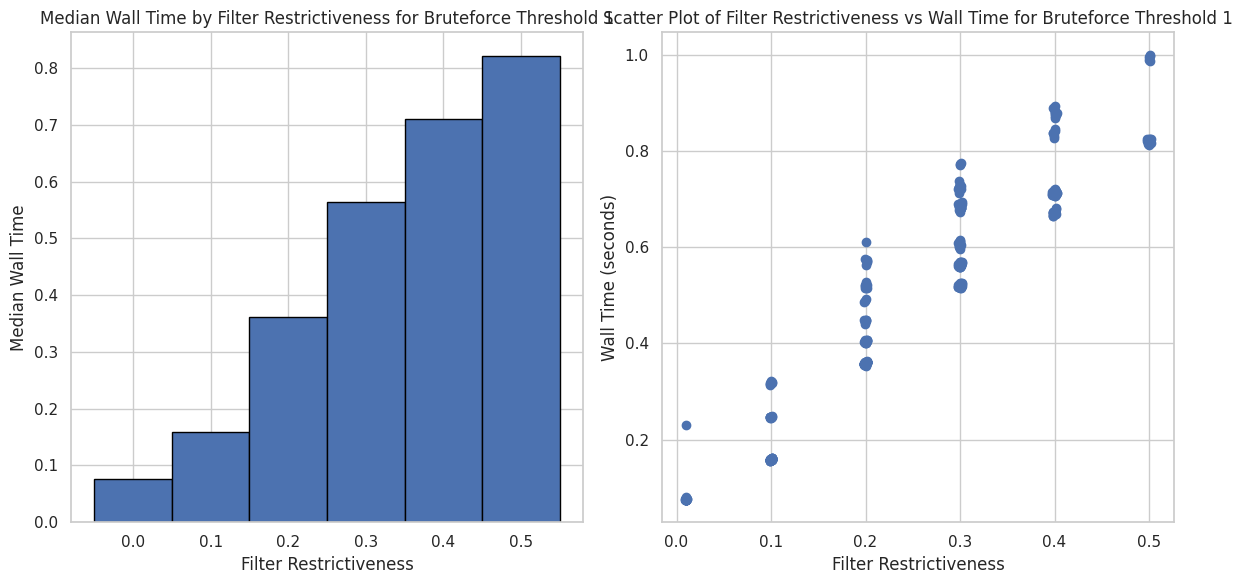

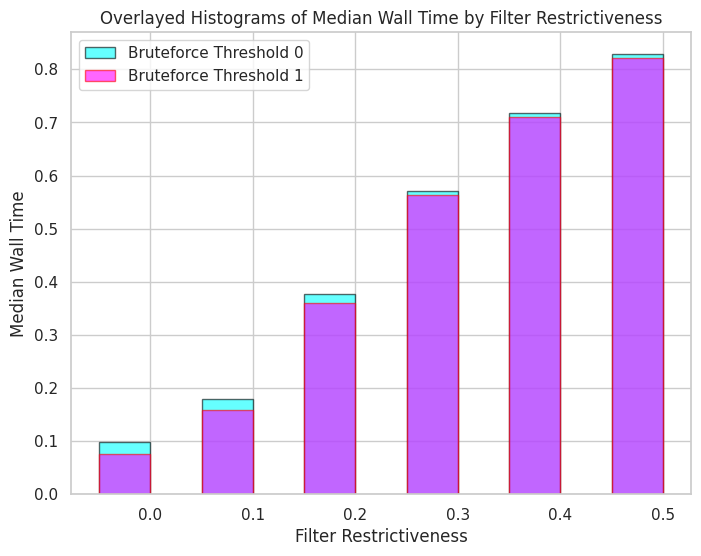

In [43]:
hist_data = {}

for bruteforce_param in [0, 1]:
    vis_queries_evaluated = perform_queries(500, 0, bruteforce_param, 1, True)

    vis_lmi_indexes = []
    for i, result in enumerate(vis_queries_evaluated):
            vis_lmi_indexes.append(i)

    assert len(vis_lmi_indexes) >= 100

    vis_queries_wall_time = [result['wall_time'] for result in vis_queries_evaluated]
    vis_queries_wall_time = [vis_queries_wall_time[i] for i in vis_lmi_indexes]

    vis_queries_filter_restrictiveness = [result['filter_restrictiveness'] for result in vis_queries_evaluated]
    vis_queries_filter_restrictiveness = [vis_queries_filter_restrictiveness[i] for i in vis_lmi_indexes]

    data_wall_time_per_restrictiveness = pd.DataFrame({
        'Filter Restrictiveness': vis_queries_filter_restrictiveness,
        'Wall Time': vis_queries_wall_time
    })

    bin_edges = np.arange(-0.05, 0.55, 0.1)
    bin_indices = pd.cut(data_wall_time_per_restrictiveness['Filter Restrictiveness'], bins=bin_edges, include_lowest=True, labels=False)

    # Initialize bin_medians array with zeros for each bin
    bin_medians = np.zeros(len(bin_edges) - 1)

    # Calculate the median for each bin and update the corresponding index in bin_medians
    grouped_data = data_wall_time_per_restrictiveness.groupby(bin_indices)['Wall Time']
    for i in range(len(bin_edges) - 1):
        if i in grouped_data.groups:
            bin_medians[i] = grouped_data.get_group(i).median()
        else:
            bin_medians[i] = 0  # Default value for bins with no data

    # Store histogram data for overlay plot
    hist_data[bruteforce_param] = (bin_edges[:-1], bin_medians)

    # Original figures within the loop
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].bar(bin_edges[:-1], bin_medians, width=0.1, align='edge', edgecolor='black')
    axs[0].set_xlabel('Filter Restrictiveness')
    axs[0].set_ylabel('Median Wall Time')
    axs[0].set_title(f'Median Wall Time by Filter Restrictiveness for Bruteforce Threshold {bruteforce_param}')

    axs[1].scatter(data_wall_time_per_restrictiveness['Filter Restrictiveness'], data_wall_time_per_restrictiveness['Wall Time'])
    axs[1].set_xlabel('Filter Restrictiveness')
    axs[1].set_ylabel('Wall Time (seconds)')
    axs[1].set_title(f'Scatter Plot of Filter Restrictiveness vs Wall Time for Bruteforce Threshold {bruteforce_param}')
    plt.tight_layout()
    plt.show()

# Overlayed histograms after the loop
plt.figure(figsize=(8, 6))

# Histogram for bruteforce_param=0 with a distinct color
plt.bar(hist_data[0][0], hist_data[0][1], width=0.05, align='edge', color='cyan', edgecolor='black', alpha=0.6, label='Bruteforce Threshold 0')

# Histogram for bruteforce_param=1 with a different distinct color
plt.bar(hist_data[1][0], hist_data[1][1], width=0.05, align='edge', color='magenta', edgecolor='red', alpha=0.6, label='Bruteforce Threshold 1')

plt.xlabel('Filter Restrictiveness')
plt.ylabel('Median Wall Time')
plt.title('Overlayed Histograms of Median Wall Time by Filter Restrictiveness')
plt.legend()
plt.show()

### Benchmark Constraint Search

In [44]:
%%time
total_queries = 500

start = time.time()
queries_results = perform_queries(total_queries, -1, 0.1, 1)
end = time.time()
wall_time = end - start

CPU times: user 3min 31s, sys: 3.42 s, total: 3min 34s
Wall time: 3min 34s


### Evaluation

In [45]:
queries_precision = list((calculate_precision(tests[i]["closest_ids"], result['ids'][0]) for i, result in enumerate(queries_results)))
lmi_queries_indexes = []
for i, result in enumerate(queries_results):
    if not result['bruteforce_used']:
        lmi_queries_indexes.append(i)
lmi_used_num = len(lmi_queries_indexes)

In [46]:
print('Number of times LMI was used', len(lmi_queries_indexes))
bruteforce_used = total_queries - lmi_used_num

lmi_precisions = [queries_precision[i] for i in lmi_queries_indexes]
if len(lmi_precisions) > 0:
    print('lmi_average_precision', sum(lmi_precisions) / len(lmi_precisions))
    print('lmi_median_precision', statistics.median(lmi_precisions))

Number of times LMI was used 362
lmi_average_precision 0.20011049723756874
lmi_median_precision 0.2


In [47]:
# print(queries_evaluated)
indexes = [i for i, val in enumerate(queries_precision) if val == 0.0]
print("indexes with zero precision: ", indexes)

indexes with zero precision:  [348]


In [48]:
avg_precision = sum(queries_precision) / len(queries_precision)
print("Average precision: ", avg_precision)
print("Median precision: ", statistics.median(queries_precision))
print("Wall Time ", wall_time)

Average precision:  0.4208800000000003
Median precision:  0.24
Wall Time  214.79319047927856


In [49]:
file_path = f"./benchmark_{dataset_name}_{total_queries}q.json"

# Check if the file exists
if not os.path.exists(file_path):
    # Create a new file with an empty JSON object
    with open(file_path, 'w') as file:
        json.dump({}, file)

# Now, load the file (which is guaranteed to exist)
with open(file_path, 'r') as file:
    chroma_results = json.load(file)

In [50]:
chroma_results['chroma_lmi'] = {}
chroma_results['chroma_lmi']['avg_precision'] = avg_precision
chroma_results['chroma_lmi']['median_precision'] = statistics.median(queries_precision)
chroma_results['chroma_lmi']['wall time'] = wall_time

In [51]:
chroma_results

{'chroma_lmi': {'avg_precision': 0.4208800000000003,
  'median_precision': 0.24,
  'wall time': 214.79319047927856}}

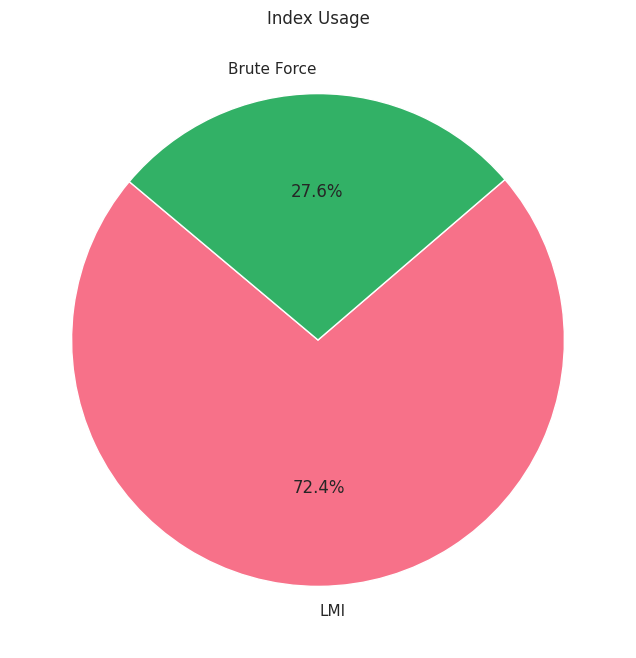

In [52]:
# Setting up the color palette from seaborn specifically for nice purple and green
colors = sns.color_palette("husl", 8)  # Using a color palette with more colors

# Creating the pie chart
plt.figure(figsize=(8,8))
plt.pie([lmi_used_num, bruteforce_used], labels=["LMI", "Brute Force"], 
        colors=[colors[0], colors[3]],  # Selecting nice colors from the palette (Purple and Green)
        autopct='%1.1f%%', startangle=140)

plt.title('Index Usage')
plt.show()

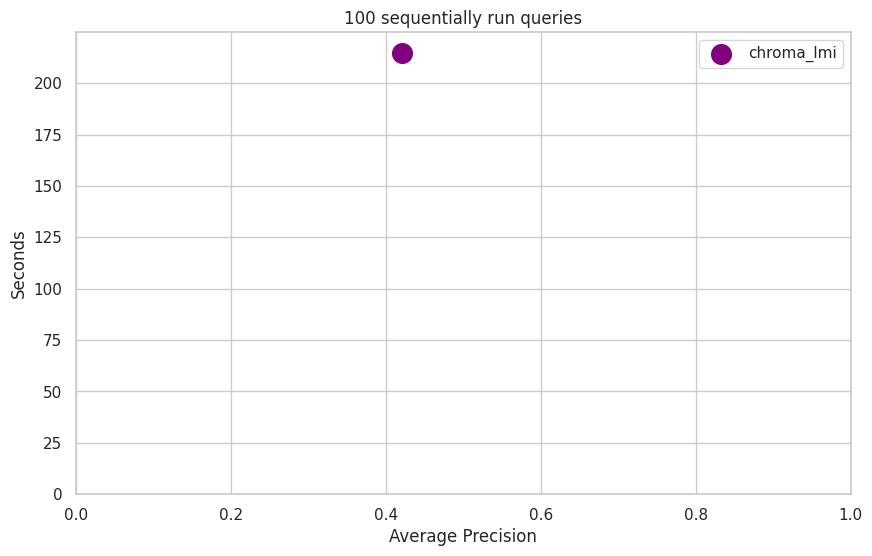

In [53]:
plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid")

# Plot each point with round, filled markers and ensure x-axis is from 0 to 1, y-axis starts at 0
for key, value in chroma_results.items():
    color = 'blue' if key == 'chroma_hnsw' else 'purple'
    plt.scatter(value['avg_precision'], value['wall time'], label=key, color=color, s=200)  # s is the size of marker

# Labeling the axes and title
plt.xlabel('Average Precision')
plt.ylabel('Seconds')
plt.title('100 sequentially run queries')
plt.xlim(0, 1)  # Ensuring x-axis covers 0 to 1 range
if chroma_results.get('chroma_hnsw', False):
    plt.ylim(0, max(chroma_results['chroma_hnsw']['wall time'], chroma_results['chroma_lmi']['wall time']) + 10)  # Ensuring y-axis starts at 0
else:
    plt.ylim(0, max(0, chroma_results['chroma_lmi']['wall time']) + 10)
plt.legend()

plt.show()